<a href="https://colab.research.google.com/github/m-aliabbas/MedicalImageClassification/blob/master/CovidMobileNetMulti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality

import os
from cv2 import imread, createCLAHE
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
import scipy as sp
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import skimage

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

print(fastai.__version__)

1.0.61


In [0]:
def set_seed(seed=42):
    
    import random
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)
    
set_seed()

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
unZip('/content/drive/My Drive/dataCov.zip')

Done!


In [0]:
!ls dataCov/Covid

 01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
 03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg
 1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg
 16654_1_1.png
 16654_2_1.jpg
 16654_4_1.jpg
 16660_1_1.jpg
 16660_2_1.jpg
 16660_3_1.jpg
 16660_4_1.jpg
 16660_5_1.jpg
 16663_1_1.jpg
 16663_1_2.jpg
 16664_1_1.jpg
 16664_2_1.jpg
 16669_1_1.jpeg
 16669_3_1.jpeg
 16672_1_1.jpg
 16673_2_1.jpg
 16674_1_1.jpg
 16691_1_1.jpg
 16706_1_1.png
 16708_1_1.jpg
 16708_4_1.jpg
 16708_5_1.jpg
 16724_1_1.jpg
 171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg
 1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2a.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png
 1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4a.png
 1.C

In [0]:
import glob
filesPos= sorted(glob.glob('dataCov/Covid/*.png'))
filesPos+= sorted(glob.glob('dataCov/Covid/*.jpeg'))
filesPos+= sorted(glob.glob('dataCov/Covid/*.jpg'))
filesNeg=sorted(glob.glob('dataCov/Normal/*.png'))[:500]
filesPnuemonia=sorted(glob.glob('dataCov/ViralPnuemonia/*.png'))[:500]

In [0]:
pos_labels=[[i,1] for i in filesPos] #have Pnuemonia
neg_labels=[[i,0] for i in filesNeg] #dont have pnuemonia
filesPnuemonia=[[i,2] for i in filesPnuemonia] #dont have pnuemonia
ds=pos_labels+neg_labels+filesPnuemonia

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
df

,path,label
1091,dataCov/ViralPnuemonia/Viral Pneumonia (1175).png,2
757,dataCov/Normal/NORMAL (263).png,0
809,dataCov/Normal/NORMAL (356).png,0
1438,dataCov/ViralPnuemonia/Viral Pneumonia (556).png,2
1109,dataCov/ViralPnuemonia/Viral Pneumonia (121).png,2
...,...,...
559,dataCov/Normal/NORMAL (1137).png,0
1293,dataCov/ViralPnuemonia/Viral Pneumonia (316).png,2
339,dataCov/Covid/nejmoa2001191_f4.jpeg,1
1012,dataCov/ViralPnuemonia/Viral Pneumonia (1044).png,2


In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.15, random_state=42)

In [0]:
bs =16
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.2,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:

import torch 
import torchvision
model = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [0]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
num_ftrs = 1280
model.classifier=nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(data.classes)),
    
)

In [0]:
model=model.cuda()

In [0]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy])

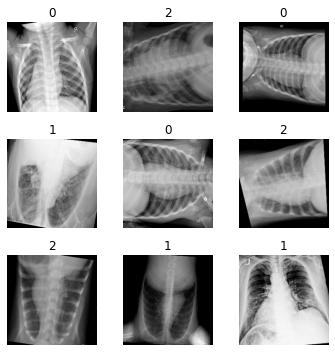

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn.unfreeze()
learn.fit(7,1e-4,wd=0.9)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.387902,0.214940,0.083333,0.916667,01:05
1,0.245323,0.182040,0.063492,0.936508,01:05
2,0.196573,0.125020,0.035714,0.964286,01:03
3,0.177096,0.158737,0.047619,0.952381,01:04
4,0.143518,0.139894,0.027778,0.972222,01:04
5,0.156676,0.131163,0.047619,0.952381,01:03
6,0.153102,0.176189,0.067460,0.932540,01:02


In [0]:
bs =8
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTest,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.0) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [0]:
preds,y, loss = learn.get_preds(with_loss=True)

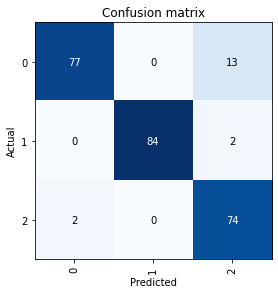

In [0]:
from sklearn.metrics import f1_score
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()


Precision of Model = 1.0 Recall of Model  1.0
F1 Score of Model = 1.0


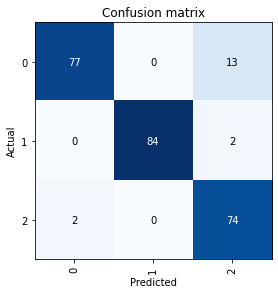

In [0]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

In [0]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve"
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9995797142056598


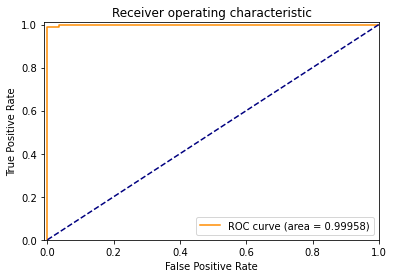

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")